In [127]:
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from tqdm import tqdm
np.random.seed(0)

# Fitting a 2AFC psychometric function

Consider a two-alternative forced-choice (2AFC) psychophysical experiment (fancy name: heterochromatic brightness matching). Subjects are shown a blue spot and a red spot and must decide which appears brighter. The intensity of the blue spot is fixed, and that of the red spot is randomly varied over trials. The purpose of the experiment is to estimate the intensity of red that matches the blue as well as the difference in intensity required for the two to be noticeably different. For a red spot of brightness $I$, the probability of the observer saying “The red spot is brighter” is:

$p(I) = λ ∗ 12 + (1 − λ) ∗ Φ(I; μ, σ)$,

where $Φ(I;μ,σ)$ is the cumulative distribution function of the Gaussian (an erf function, normcdf in matlab) with mean $μ$ and standard deviation $σ$, evaluated at $I$. The parameter $λ$ is called the “lapse rate” and is the proportion of trials the observer didn’t pay attention and just guessed. The function $p(I)$ is known as the psychometric function.
You will start by simulating performance in this task. Then, you’ll simulate the inverse (scientific) side of the problem, and use this probabilistic model as a means of fitting/analyzing the simulated data set, estimating its parameters and comparing models.

In [3]:
from scipy.stats import norm 

def erf(x, mu, sigma):
    return norm.cdf(x, loc=mu, scale=sigma)

def psychometric(I, lambd, mu, sigma):
    return lambd * 0.5 + (1 - lambd) * erf(I, mu, sigma)

# a)
Write a function `B=simpsych(lambda,mu,sigma,I,T)` to simulate an experiment. The arguments $(I,T)$ are vectors of equal length, the first containing a list of intensities and the second containing the number of trials to be run for each corresponding intensity. The function should generate draws from $p(I)$, and return a vector, $B$, (of the same length as $I$ and $T$), containing the number of trials for which the simulated observer responded that the red spot was brighter, for each intensity $I$.

In [4]:
from scipy.stats import binom

def simpsych(lambd, mu, sigma, I, T):
    psych = psychometric(I, lambd, mu, sigma)
    return binom.rvs(n=T, p=psych)

# b)
Illustrate the use of simpsych with `T=ones(1,7)*100` and `I=1:7` for $λ = 0.05$, $μ = 4$ and $σ = 1$. Plot `B ./ T` vs `I` (as points) and plot the psychometric function $p(I)$ (as a curve) on the same graph.

In [5]:
intensities = np.arange(1, 8)
ntrials = 100 * np.ones(7, dtype='int')
nsuccess = simpsych(lambd=0.05, mu=4, sigma=1, I=intensities, T=ntrials)

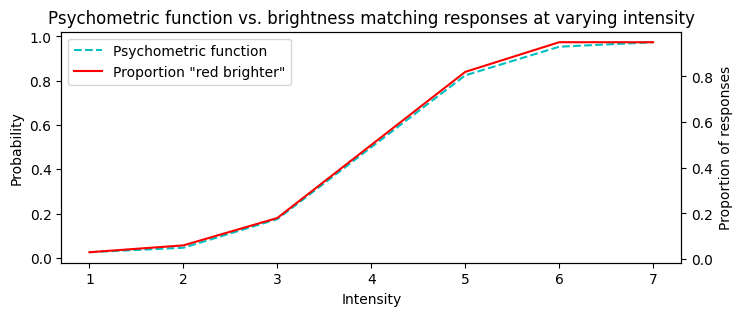

In [23]:
fig, ax1 = plt.subplots(figsize=(8, 3))
ax2 = plt.twinx()
psych_fn = psychometric(intensities, lambd=0.05, mu=4, sigma=1)
l1, = ax1.plot(intensities, psych_fn, 'c--')
l2, = ax2.plot(intensities, nsuccess / ntrials, 'r')
ax1.legend([l1, l2], ['Psychometric function', 'Proportion "red brighter"'])
ax1.set_xlabel('Intensity')
ax1.set_ylabel('Probability')
ax2.set_ylabel('Proportion of responses')
plt.title('Psychometric function vs. brightness matching responses at varying intensity')
plt.show()

# c)
Do the same with `T=ones(1,7)*10` and plot the results (including the psychometric function). What is the difference between this and the plot of the previous question?

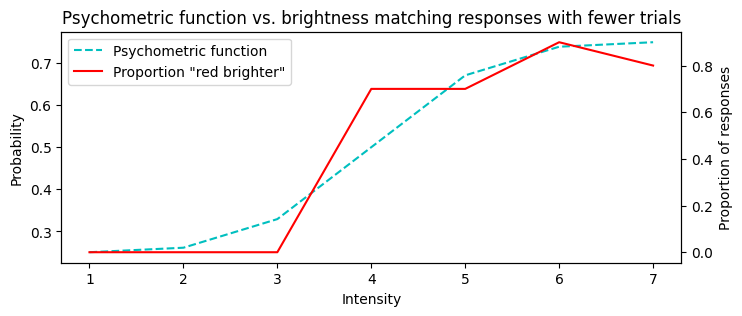

In [7]:
ntrials2 = 10 * np.ones(7, dtype='int')
nsuccess2 = simpsych(lambd=0.05, mu=4, sigma=1, I=intensities, T=ntrials2)
fig, ax1 = plt.subplots(figsize=(8, 3))
ax2 = plt.twinx()
l1, = ax1.plot(intensities, psych_fn, 'c--')
l2, = ax2.plot(intensities, nsuccess2 / ntrials2, 'r')
ax1.legend([l1, l2], ['Psychometric function', 'Proportion "red brighter"'])
ax1.set_xlabel('Intensity')
ax1.set_ylabel('Probability')
ax2.set_ylabel('Proportion of responses')
plt.title('Psychometric function vs. brightness matching responses with fewer trials')
plt.show()

In this plot, the proportion of "red brighter" doesn't match the psychometric function as well. Variation in the response proportion is greater because the number of trials is lower. This results in estimates with greater dispersion around the underlying psychometric value.

# d)
Write a function `nll = nloglik(mu,sigma,lambda,I,T,B)` that returns the negative log likelihood of parameters `mu`, `sigma`, and `lambda` for data set `I,T,B` (we’re negating it because we will be minimizing this function to solve for the optimal parameters).

In [52]:
def nloglik(mu, sigma, lambd, I, T, B):
    psych = psychometric(I, lambd, mu, sigma)
    likelihoods = binom.pmf(k=B, n=T, p=psych)
    return -np.sum(np.log(likelihoods))

# e)
Use the matlab function `fminsearch` to estimate the values of `mu`, `sigma`, and `lambda` that minimize the function `nloglik(mu,sigma,lambda,...)` for the dataset you generated in (b). You’ll need to specify a start point for the search – for this problem, `[2,2,.05]` is a reasonable choice. Were the estimates close to the true values used to generate the data?

In [64]:
from scipy.optimize import minimize

x0 = [2, 2, 0.5]
optimizer = minimize(lambda x: nloglik(x[0], x[1], x[2], intensities, ntrials, nsuccess), x0, method="Nelder-Mead")
x_opt = optimizer.x
print("Estimated values:")
print(f"mu: {x_opt[0]}")
print(f"sigma: {x_opt[1]}")
print(f"lambda: {x_opt[2]}")

Estimated values:
mu: 3.994884304565403
sigma: 0.9717290920129736
lambda: 0.07656418667196602


The estimates are close to the true values $\mu=4$, $\sigma=1$ and $\lambda=0.05$ used to generate the data.

# f)
A variant of `fminsearch`, `fminunc`, also returns the Hessian (the matrix of second derivatives) of the negative log likelihood at the optimal values `mu`, `sigma` and `lambda`. (Note: `fminunc` is less robust than `fminsearch`, and if the optimizer strays too far from the true values, there may be numerical problems due to overflow of the likelihood; in this case, try a different starting point.) The inverse of the Hessian provides an estimate of the covariance matrix of the parameter estimates. Use this to determine 95% confidence intervals on each parameter (Hint: a 95% confidence interval is the mean ±1.96 standard deviations of the parameter estimate. Compute the standard deviation of a marginal of the 3-D Gaussian that has covariance equal to the inverse Hessian.) Do the true parameter values (4, 1 and .05) fall within these confidence intervals?

In [42]:
def marginal_std(C, axis):
    u = np.identity(C.shape[0])[axis]
    var = u @ C @ u
    return np.sqrt(var)

def confidence_interval(mu, std):
    return (mu - std * 1.96, mu + std * 1.96)

In [63]:
x0 = [4, 1, 0.05]
f = lambda x: nloglik(x[0], x[1], x[2], intensities, ntrials, nsuccess)
optimizer = minimize(f, x0, method="BFGS")
x_opt = optimizer.x
cov = optimizer.hess_inv
print("Estimated values:")
print(f"mu: {x_opt[0]}")
print(f"sigma: {x_opt[1]}")
print(f"lambda: {x_opt[2]}")

Estimated values:
mu: 3.9948886239779053
sigma: 0.9717287033252878
lambda: 0.07657618185539616


In [62]:
x_std = np.array([
    marginal_std(cov, axis=0),
    marginal_std(cov, axis=1),
    marginal_std(cov, axis=2)
])
print("Standard deviation:")
print(f"mu: {x_std[0]}")
print(f"sigma: {x_std[1]}")
print(f"lambda: {x_std[2]}")

Standard deviation:
mu: 0.0865179015471084
sigma: 0.12067645082165726
lambda: 0.025603951372538684


In [61]:
intervals = confidence_interval(x_opt, x_std)
print("Confidence intervals:")
for i, var in enumerate(['mu', 'sigma', 'lambda']):
    print(f'{var}: [{intervals[0][i]}, {intervals[1][i]}]')

Confidence intervals:
mu: [3.825313536945573, 4.164463711010238]
sigma: [0.7352028597148396, 1.208254546935736]
lambda: [0.026392437165220342, 0.126759926545572]


**Yes**, the true parameters (4, 1 and .05) fall within the 95% confidence intervals for `mu`, `sigma` and `lambda`. But the marginal has relatively large standard deviations for `sigma` and `lambda` compared to their parameter values, indicating a low-certainty estimate.

# g)
Produce a second set of confidence intervals for the parameters using a bootstrap method. For each of the 7 intensities, resample 100 trials (i.e., responses that the red spot is brighter or darker) from the 100 trials of that intensity in the original data, with replacement. Refit the model to the resampled data using `fminsearch`. Plot the histograms (function `hist`) of `mu`, `sigma` and `lambda` estimates obtained over 500 such resampled datasets, and define your confidence intervals as the region between the 2.5th and 97.5th percentiles of these distributions. How well do these values agree with those from part (f)?

In [46]:
def resample_dataset(nsuccess):
    B = np.zeros_like(nsuccess, dtype='int')
    for i, k in enumerate(nsuccess):
        outcomes = np.zeros(100)
        outcomes[:k] = 1
        inds = np.random.choice(100, 100, replace=True)
        B[i] = np.sum(outcomes[inds])
    return B

In [95]:
def fit(x0, I, T, B):
    f = lambda x: nloglik(x[0], x[1], x[2], I, T, B)
    optimizer = minimize(f, x0, method="Nelder-Mead")
    x_opt = optimizer.x
    return x_opt

In [96]:
X_opt = np.zeros((500, 3))
for i in tqdm(range(500)):
    B = resample_dataset(nsuccess)
    x0 = [4, 1, 0.05]
    X_opt[i, :] = fit(x0, intensities, 100, B)

100%|████████████████████████████████████████| 500/500 [00:03<00:00, 148.44it/s]


In [97]:
intervals = np.quantile(X_opt, [0.025, 0.975], axis=0)
for i, var in enumerate(['mu', 'sigma', 'lambda']):
    print(f'{var}: [{intervals[0][i]}, {intervals[1][i]}]')

mu: [3.8184081247796366, 4.173963001589091]
sigma: [0.7299420262903902, 1.217981005492785]
lambda: [0.023001810241256627, 0.12556495543544738]


These values **agree well** with those from part (f).

# i)

Simulate the experiment using `simpsych` twice, once using the original parameters and again changing the `mu` value to 6. We now consider a couple of approaches to test whether those two datasets differ significantly in `mu`. First, pool the datasets (treat it as one big dataset for a single psychometric function) and fit using your code from part (d). Now, write a new function, `nloglik2`, that computes the likelihood of a 4-parameter model: shared values of `sigma` and `lambda` for the two datasets, but separate parameters `mu1` and `mu2` for each dataset. Fit this model to the data from the two simulations. Report the fit parameters for these. Now, compare the two models using AIC and BIC (reusing the results of the fit from part (g)). What are the AIC and BIC statistics and do they “seem” large enough to support the more complex model (i.e., that the two `mu` values differ)?

In [98]:
nsuccess1 = simpsych(lambd=0.05, mu=4, sigma=1, I=intensities, T=ntrials)
nsuccess2 = simpsych(lambd=0.05, mu=6, sigma=1, I=intensities, T=ntrials)

Fit using `nloglik`:

In [57]:
x0 = [5, 1, 0.05]
fit(x0, intensities, 2 * ntrials, nsuccess1 + nsuccess2)
print(f"mu: {x_opt[0]}")
print(f"sigma: {x_opt[1]}")
print(f"lambda: {x_opt[2]}")

mu: 4.096775966348485
sigma: 6.034264364166409
lambd: 1.1300996814082842


In [102]:
def nloglik2(mu1, mu2, sigma, lambd, I, T, B1, B2):
    psych1 = psychometric(I, lambd, mu1, sigma)
    psych2 = psychometric(I, lambd, mu2, sigma)
    likelihood1 = binom.pmf(k=B1, n=T, p=psych1)
    likelihood2 = binom.pmf(k=B2, n=T, p=psych2)
    return -np.sum(np.log(likelihood1) + np.log(likelihood2))

Fit using `nloglik2`:

In [53]:
x0 = [4, 6, 1, 0.05]
f = lambda x: nloglik2(x[0], x[1], x[2], x[3], intensities, ntrials, nsuccess1, nsuccess2)
optimizer = minimize(f, x0, method="Nelder-Mead")
x_opt = optimizer.x
print(f"mu1: {x_opt[0]}")
print(f"mu2: {x_opt[1]}")
print(f"sigma: {x_opt[2]}")
print(f"lambda: {x_opt[3]}")

mu1: 4.096775966348485
mu2: 6.034264364166409
sigma: 1.1300996814082842
lambd: 0.03039780700037924


Compute AIC and BIC for pooled dataset using `nloglik` and `X_opt` from part (g):

In [51]:
theta = X_opt.mean(axis=0)
data = nsuccess1 + nsuccess2
nll = nloglik(*theta, intensities, 2 * ntrials, data)
aic = 2 * len(theta) + 2 * nll
bic = len(theta) * np.log(len(data)) + 2 * nll
print(f"AIC: {aic}")
print(f"BIC: {bic}")

AIC: 352.1862375882357
BIC: 352.02396803540165


Compute AIC and BIC for datasets using `nloglik2` and `x_opt` above:

In [50]:
theta = x_opt
data1 = nsuccess1
data2 = nsuccess2
nll = nloglik2(*theta, intensities, ntrials, data1, data2)
aic = 2 * len(theta) + 2 * nll
bic = len(theta) * np.log(len(data1) + len(data2)) + 2 * nll
print(f"AIC: {aic}")
print(f"BIC: {bic}")

AIC: 68.43124588935922
BIC: 70.98747520782025


The AIC and BIC values for the complex model are around 65, and those for the simple value are around 265. The simple model AIC/BIC values are of O(100); these are values for a well-fit model. So, I think the AIC/BIC values for the complex model, which are also of O(100), indicate a relatively good fit. I think the complex model **is supported** by these AIC/BIC values.

# i)

Finally, construct a permutation test of the null hypothesis (i.e., the hypothesis that there has been no change in mu between the two datasets). For each intensity, combine the 100 trials from each condition into a total of 200, then randomly partitioning this into two groups of 100. Fit both resampled datasets with your original one-sample model, noting the difference between the two mu estimates. Repeat this process 500 times to produce a null distribution of the differences. Now fit the two datasets separately and compute the difference between the two `mu` estimates. How likely (at what quantile; one- tailed p-value) is that difference in `mu` according to the null distribution? Do these results make sense given the true parameter values from which you simulated the datasets?

In [107]:
def resample_datasets(nsuccess1, nsuccess2):
    resampled1 = np.zeros_like(nsuccess1)
    resampled2 = np.zeros_like(nsuccess2)
    for i, n in enumerate(nsuccess1 + nsuccess2):
        t = np.zeros(200)
        t[:n] = 1
        np.random.shuffle(t)
        n1 = np.sum(t[:100])
        n2 = np.sum(t[100:])
        resampled1[i] = n1
        resampled2[i] = n2
    return resampled1, resampled2

In [121]:
resampled1, resampled2 = resample_datasets(nsuccess1, nsuccess2)

In [137]:
def fit_separate(data1, data2):
    x0 = [5, 1, 0.05]
    x_opt1 = fit(x0, intensities, 100, data1)
    x_opt2 = fit(x0, intensities, 100, data2)
    mu1 = x_opt1[0]
    mu2 = x_opt2[0]
    return mu1, mu2

In [54]:
mu1, mu2 = fit_separate(resampled1, resampled2)
print("Shuffled:")
print(f"mu1: {mu1}")
print(f"mu2: {mu2}")

Shuffled:
mu1: 4.98048012487245
mu2: 5.128734206113913


When the datasets are shuffled across each other, both give estimates of `mu` around 5.

Let's repeat 500 times and get a null distribution over `mu2 - mu1`:

In [32]:
diffs = np.zeros(500)
for i in tqdm(range(500)):
    resampled1, resampled2 = resample_datasets(nsuccess1, nsuccess2)
    mu1, mu2 = fit_separate(resampled1, resampled2)
    diffs[i] = np.abs(mu2 - mu1)

100%|█████████████████████████████████████████| 500/500 [00:08<00:00, 56.95it/s]


How is the test statistic distributed?

Test statistic max: 0.5064987267001086


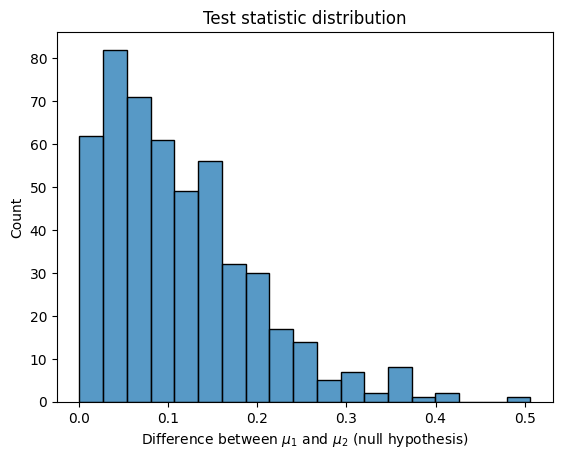

In [43]:
sns.histplot(diffs)
plt.title('Test statistic distribution')
plt.ylabel('Count')
plt.xlabel('Difference between $\mu_1$ and $\mu_2$ (null hypothesis)')
print(f"Test statistic max: {max(diffs)}")

Now fit the (unshuffled) datasets separately:

In [55]:
mu1, mu2 = fit_separate(nsuccess1, nsuccess2)
print("Unshuffled:")
print(f"mu1: {mu1}")
print(f"mu2: {mu2}")

Unshuffled:
mu1: 4.096290764492823
mu2: 6.040772323841598


These have a difference close to 2, compared to the shuffled differences which are concentrated tightly around 0.

The test statistic has a max around 0.5. Not a single value in the test statistic distribution exceeds `mu2` - `mu1` for our two original datasets. Since we drew 500 samples, this indicates a p-value <0.002.

This means it is highly, highly unlikely that the two datasets were generated by two distributions with the same $\mu$. It is sensible to conclude that we are not mistakenly assuming a difference. This does make sense given the ground truth: we generated the datasets with $\mu = 4$ and $\mu = 6$ respectively, and given enough samples, random draws from a unimodal Gaussian cannot replicate them.